In [1]:
from lightgbm import LGBMClassifier
from lightgbm import train
from matplotlib.pyplot import plot
from numpy import nan
from numpy import ndarray
from numpy import unique
from pandas import DataFrame
from pandas import read_csv
from pandas import Series
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder

In [2]:
import pandas as pd

TRAIN = '../input/spaceship-titanic/train.csv'
train_df = pd.read_csv(filepath_or_buffer=TRAIN)

In [3]:
def prepare(input_df: DataFrame) -> ndarray:
    result_df = input_df.drop(columns=['Transported', ], errors='ignore').copy(deep=True)
    result_df['Cabin_Deck'] = result_df['Cabin'].apply(func=lambda x: 'Unknown' if isinstance(x, float) else x.split('/')[0])
    result_df['Cabin_Side'] = result_df['Cabin'].apply(func=lambda x: 'Unknown' if isinstance(x, float) else x.split('/')[2])
    columns = ['CryoSleep', 'Destination', 'HomePlanet', 'Cabin_Deck', 'Cabin_Side', 'VIP']
    for column in columns:
        result_df[column] = LabelEncoder().fit_transform(y=result_df[column])
    result_df = result_df.drop(columns=['Cabin', 'Name', 'PassengerId',])
    return result_df

# get the labels
y = train_df['Transported'].values
x_df = prepare(input_df=train_df)
imputer = KNNImputer(missing_values=nan, n_neighbors=2, weights='uniform', metric='nan_euclidean', copy=True, add_indicator=False,)
x = imputer.fit_transform(x_df)

In [4]:
from sklearn.model_selection import train_test_split

RANDOM_STATE = 2024
x, x_test, y, y_test = train_test_split(x, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

In [5]:
model = LGBMClassifier(
    boosting_type=['gbdt', 'dart', 'goss',][0], 
    class_weight=None, 
    colsample_bytree=1.0, 
    early_stopping_round = 25, # was 20
    importance_type=['gain', 'split'][1],
    learning_rate = 0.01,
    max_depth=-1,  
    min_child_weight=0.001, 
    min_child_samples=20, 
    min_split_gain=0.0, 
    n_estimators=[50, 100, 150, 200, 1000][4], 
    n_jobs=None, 
    num_leaves=31,
    objective=None, 
    random_state=RANDOM_STATE, 
    reg_alpha=0.0, 
    reg_lambda=0.0, 
    subsample_for_bin=200000, 
    subsample=1.0, 
    subsample_freq=0, 
)

In [6]:
model.fit(X=x, y=y, eval_set=(x_test, y_test), feature_name='auto', categorical_feature='auto',)

[1]	valid_0's binary_logloss: 0.689064
[2]	valid_0's binary_logloss: 0.685106
[3]	valid_0's binary_logloss: 0.681302
[4]	valid_0's binary_logloss: 0.677506
[5]	valid_0's binary_logloss: 0.673791
[6]	valid_0's binary_logloss: 0.670183
[7]	valid_0's binary_logloss: 0.66663
[8]	valid_0's binary_logloss: 0.66315
[9]	valid_0's binary_logloss: 0.659735
[10]	valid_0's binary_logloss: 0.656357
[11]	valid_0's binary_logloss: 0.653073
[12]	valid_0's binary_logloss: 0.649847
[13]	valid_0's binary_logloss: 0.646687
[14]	valid_0's binary_logloss: 0.643596
[15]	valid_0's binary_logloss: 0.640561
[16]	valid_0's binary_logloss: 0.637555
[17]	valid_0's binary_logloss: 0.634604
[18]	valid_0's binary_logloss: 0.631591
[19]	valid_0's binary_logloss: 0.628713
[20]	valid_0's binary_logloss: 0.625884
[21]	valid_0's binary_logloss: 0.62312
[22]	valid_0's binary_logloss: 0.620294
[23]	valid_0's binary_logloss: 0.617627
[24]	valid_0's binary_logloss: 0.614927
[25]	valid_0's binary_logloss: 0.61238
[26]	valid_0'

LGBMClassifier(early_stopping_round=25, learning_rate=0.01, n_estimators=1000,
               n_jobs=None, random_state=2024)

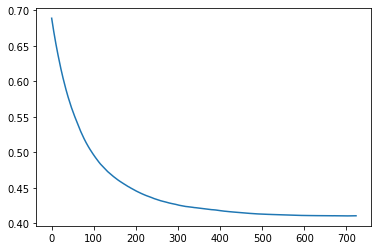

In [7]:
plot(model.evals_result_['valid_0']['binary_logloss'])

<AxesSubplot:>

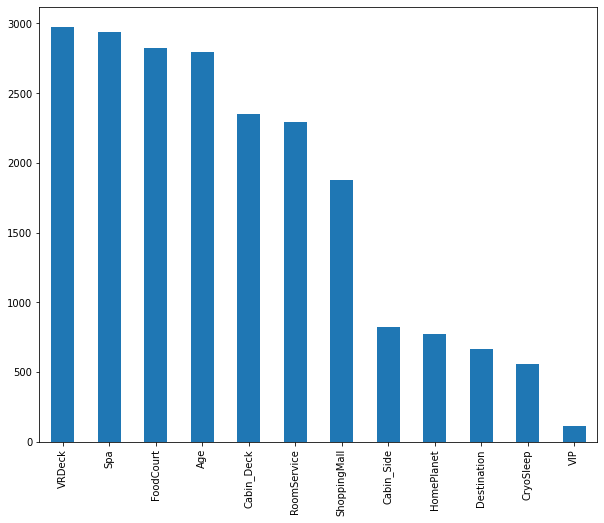

In [8]:
importance = Series(model.feature_importances_, index=x_df.columns)
importance.nlargest(30).plot(kind='bar', figsize=(10, 8))

In [9]:
submission_df = read_csv('../input/spaceship-titanic/test.csv')
ids = submission_df['PassengerId'].values
submission_data_df = prepare(input_df=submission_df)
submission_data = imputer.transform(submission_data_df)
output_df = DataFrame({'PassengerId': ids, 'Transported': model.predict(submission_data) == 1.0})
output_df.to_csv('submission.csv', index=False)

{False: 1996, True: 2281}

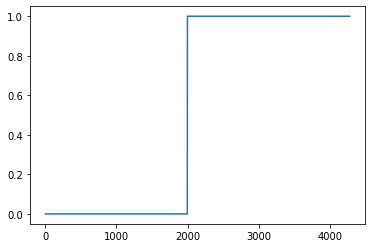

In [10]:
y_pred = model.predict(submission_data)
plot(sorted(y_pred.tolist()), )
values, counts = unique(y_pred, return_counts=True)
dict(zip(values, counts))